In [5]:
import cv2
import matplotlib.pyplot as plt

In [6]:
iml = cv2.imread("./data/left.png")

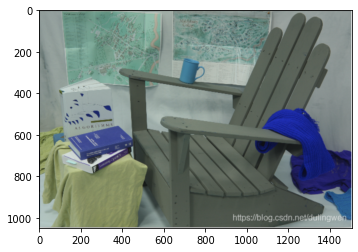

In [7]:
plt.imshow(iml)

In [4]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
import stereoconfig
import os
# pcl库也可以用于显示3维点云，但是安装过程可能较为麻烦
#import pcl
#import pcl.pcl_visualization
# 此代码用pptk来显示 pip install pptk -i https://pypi.douban.com/simple 即可
 
 
# 预处理
def preprocess(img1, img2):
    # 彩色图->灰度图
    im1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
 
    # 直方图均衡
    im1 = cv2.equalizeHist(im1)
    im2 = cv2.equalizeHist(im2)
 
    return im1, im2
 
 
# 消除畸变
def undistortion(image, camera_matrix, dist_coeff):
    undistortion_image = cv2.undistort(image, camera_matrix, dist_coeff)
 
    return undistortion_image
 
 
# 获取畸变校正和立体校正的映射变换矩阵、重投影矩阵
# @param：config是一个类，存储着双目标定的参数:config = stereoconfig.stereoCamera()
def getRectifyTransform(height, width, config):
    # 读取内参和外参
    left_K = config.cam_matrix_left
    right_K = config.cam_matrix_right
    left_distortion = config.distortion_l
    right_distortion = config.distortion_r
    R = config.R
    T = config.T
 
    # 计算校正变换
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(left_K, left_distortion, right_K, right_distortion, (width, height), R, T, alpha=0)
 
    map1x, map1y = cv2.initUndistortRectifyMap(left_K, left_distortion, R1, P1, (width, height), cv2.CV_32FC1)
    map2x, map2y = cv2.initUndistortRectifyMap(right_K, right_distortion, R2, P2, (width, height), cv2.CV_32FC1)
 
    return map1x, map1y, map2x, map2y, Q
 
 
# 畸变校正和立体校正
def rectifyImage(image1, image2, map1x, map1y, map2x, map2y):
    rectifyed_img1 = cv2.remap(image1, map1x, map1y, cv2.INTER_AREA)
    rectifyed_img2 = cv2.remap(image2, map2x, map2y, cv2.INTER_AREA)
 
    return rectifyed_img1, rectifyed_img2
 
 
# 立体校正检验----画线
def draw_line(image1, image2):
    # 建立输出图像
    height = max(image1.shape[0], image2.shape[0])
    width = image1.shape[1] + image2.shape[1]
 
    output = np.zeros((height, width, 3), dtype=np.uint8)
    output[0:image1.shape[0], 0:image1.shape[1]] = image1
    output[0:image2.shape[0], image1.shape[1]:] = image2
 
    # 绘制等间距平行线
    line_interval = 50  # 直线间隔：50
    for k in range(height // line_interval):
        cv2.line(output, (0, line_interval * (k + 1)), (2 * width, line_interval * (k + 1)), (0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
 
    return output
 
 
# 视差计算
def stereoMatchSGBM(left_image, right_image, down_scale=False):
    # SGBM匹配参数设置
    if left_image.ndim == 2:
        img_channels = 1
    else:
        img_channels = 3
    blockSize = 3
    paraml = {'minDisparity': 0,
             'numDisparities': 128,
             'blockSize': blockSize,
             'P1': 8 * img_channels * blockSize ** 2,
             'P2': 32 * img_channels * blockSize ** 2,
             'disp12MaxDiff': 1,
             'preFilterCap': 63,
             'uniquenessRatio': 15,
             'speckleWindowSize': 100,
             'speckleRange': 1,
             'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
             }
 
    # 构建SGBM对象
    left_matcher = cv2.StereoSGBM_create(**paraml)
    paramr = paraml
    paramr['minDisparity'] = -paraml['numDisparities']
    right_matcher = cv2.StereoSGBM_create(**paramr)
 
    # 计算视差图
    size = (left_image.shape[1], left_image.shape[0])
    if down_scale == False:
        disparity_left = left_matcher.compute(left_image, right_image)
        disparity_right = right_matcher.compute(right_image, left_image)
 
    else:
        left_image_down = cv2.pyrDown(left_image)
        right_image_down = cv2.pyrDown(right_image)
        factor = left_image.shape[1] / left_image_down.shape[1]
        #import pdb
        #pdb.set_trace()
        disparity_left_half = left_matcher.compute(left_image_down, right_image_down)
        disparity_right_half = right_matcher.compute(right_image_down, left_image_down)
        disparity_left = cv2.resize(disparity_left_half, size, interpolation=cv2.INTER_AREA)
        disparity_right = cv2.resize(disparity_right_half, size, interpolation=cv2.INTER_AREA)
        disparity_left = factor * disparity_left
        disparity_right = factor * disparity_right
 
    # 真实视差（因为SGBM算法得到的视差是×16的）
    trueDisp_left = disparity_left.astype(np.float32) / 16.
    trueDisp_right = disparity_right.astype(np.float32) / 16.
 
    return trueDisp_left, trueDisp_right
 
 
# 将h×w×3数组转换为N×3的数组
def hw3ToN3(points):
    height, width = points.shape[0:2]
 
    points_1 = points[:, :, 0].reshape(height * width, 1)
    points_2 = points[:, :, 1].reshape(height * width, 1)
    points_3 = points[:, :, 2].reshape(height * width, 1)
 
    points_ = np.hstack((points_1, points_2, points_3))
 
    return points_
 
 
# 深度、颜色转换为点云
def DepthColor2Cloud(points_3d, colors):
    rows, cols = points_3d.shape[0:2]
    size = rows * cols
 
    points_ = hw3ToN3(points_3d)
    colors_ = hw3ToN3(colors).astype(np.int64)
 
    # 颜色信息
    blue = colors_[:, 0].reshape(size, 1)
    green = colors_[:, 1].reshape(size, 1)
    red = colors_[:, 2].reshape(size, 1)
 
    rgb = np.left_shift(blue, 0) + np.left_shift(green, 8) + np.left_shift(red, 16)
 
    # 将坐标+颜色叠加为点云数组
    pointcloud = np.hstack((points_, rgb)).astype(np.float32)
    pointcloud_pptk = np.hstack((points_, red,green,blue)).astype(np.float32)
    
    # 将坐标+颜色叠加为pptk显示的数组
 
    # 删掉一些不合适的点
    X = pointcloud[:, 0]
    Y = pointcloud[:, 1]
    Z = pointcloud[:, 2]
 
    remove_idx1 = np.where(Z <= 0)
    remove_idx2 = np.where(Z > 15000)
    remove_idx3 = np.where(X > 10000)
    remove_idx4 = np.where(X < -10000)
    remove_idx5 = np.where(Y > 10000)
    remove_idx6 = np.where(Y < -10000)
    remove_idx = np.hstack((remove_idx1[0], remove_idx2[0], remove_idx3[0], remove_idx4[0], remove_idx5[0], remove_idx6[0]))
 
    pointcloud_1 = np.delete(pointcloud, remove_idx, 0)
    pointcloud_pptk_1 = np.delete(pointcloud_pptk, remove_idx, 0)
    inds=np.array(range(0,pointcloud_pptk_1.shape[0]))
    return pointcloud_1,pointcloud_pptk_1,inds
 
 
# 用 pcl显示 点云显示
def view_cloud(pointcloud):
    cloud = pcl.PointCloud_PointXYZRGBA()
    cloud.from_array(pointcloud)
 
    try:
        visual = pcl.pcl_visualization.CloudViewing()
        visual.ShowColorACloud(cloud)
        v = True
        while v:
            v = not (visual.WasStopped())
    except:
        pass
 
 
if __name__ == '__main__':
    # 读取MiddleBurry数据集的图片
    # [填空] 从MiddleBurry数据集middlebury数据集：https://vision.middlebury.edu/stereo/data/scenes2014/zip/,下载一对左右图，放入2_eyes_data目录下
    iml = cv2.imread('./data/left.png' )  # 左图
    imr = cv2.imread('./data/right.png')  # 右图
    height, width = iml.shape[0:2]
    print("height=%s,width=%s"%(height,width))
    # 读取相机内参和外参
    config = stereoconfig.stereoCamera1()
 
    # 立体校正
    map1x, map1y, map2x, map2y, Q = getRectifyTransform(height, width, config)  # 获取用于畸变校正和立体校正的映射矩阵以及用于计算像素空间坐标的重投影矩阵
    iml_rectified, imr_rectified = rectifyImage(iml, imr, map1x, map1y, map2x, map2y)
    print(Q)
 
    # 绘制等间距平行线，检查立体校正的效果
    line = draw_line(iml_rectified, imr_rectified)
    cv2.imwrite('./data/检验.png', line)
    os.system("open ./data/检验.png")
 
    # 立体匹配
    iml_, imr_ = preprocess(iml, imr)  # 预处理，一般可以削弱光照不均的影响，不做也可以
    disp, _ = stereoMatchSGBM(iml_, imr_, True)  # 这里可以传入的是未经立体校正的图像，因为我们使用的middleburry图片已经是校正过的了
    cv2.imwrite('./data/视差.png', disp)
    os.system("open ./data/视差.png")
 
    #[填空] 由视差图计算像素点的3D坐标（左相机坐标系下）
    points_3d = 
    
    # 直接用视差来做为点的z坐标
    Q1 = np.zeros((4,4))
    Q1[0,0]=1.0
    Q1[1,1]=1.0
    Q1[2,2]=1.0
    Q1[3,3]=1.0
    #points_3d = cv2.reprojectImageTo3D(disp, Q1)  # 可以使用上文的stereo_config.py给出的参数
 
    # 构建点云--Point_XYZRGBA格式
    pointcloud,pc_pptk,inds= DepthColor2Cloud(points_3d, iml)
    # 将点云数据保存
    #np.savetxt("data.txt",pointcloud)
    ## 用pcl显示点云
    #view_cloud(pointcloud)
    # 用pptk来显示点云
    import pptk
    #显示点云中的点
    v = pptk.viewer(pc_pptk[:,0:3])
    # 给点上色,pc_pptk的第3，4，5列是R,G,B 
    v.attributes(pc_pptk[:,3:6]/255,inds)
    v.set(point_size=0.0001)


    #[填空] 将点云绕z轴旋转45度，得到pc_pptk_45，并重新显示
    pc_pptk_45=
    #显示点云中的点
    v = pptk.viewer(pc_pptk_45[:,0:3])
    # 给点上色,pc_pptk的第3，4，5列是R,G,B 
    v.attributes(pc_pptk_45[:,3:6]/255,inds)
    v.set(point_size=0.0001)


SyntaxError: invalid syntax (<ipython-input-4-013009ca89b2>, line 226)